# Shamir Secret Sharing

In this notebook we will study the properties of polynomials to perform secret sharing and defining the properties of sum and multiplication, the protocol we will learn is called Shamir secret sharing and was published by Adi Shamir in 1979, you can read the paper [here](http://users.cms.caltech.edu/~vidick/teaching/101_crypto/Shamir1979.pdf). At the same time will investigate the difference between Shamir secret sharing and additive secret sharing.

## Polynomials

We look at polynomials and their properties. First let's look at a simple polynomial say $$f(x)=3+x+2x^2-x^3$$

and plot it a graph. Also we plot a random sampling of the polynomial points.

<Figure size 432x288 with 0 Axes>

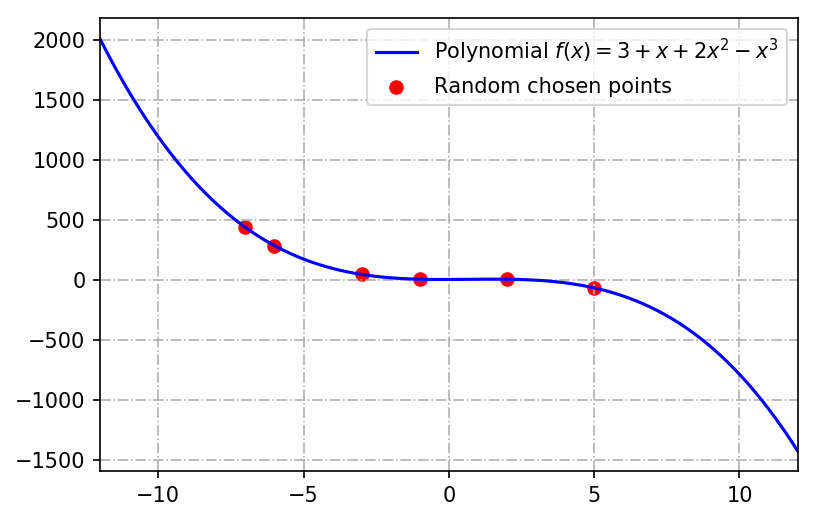

Random points are:
[(-3, 45), (-1, 5), (-7, 437), (2, 5), (5, -67), (-6, 285)]


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from random import randrange, seed

seed(4)

# Defining the polynomial
def poly3(x):
    return 3+1*x+2*x**2-x**3

# Generate 5 random points
points = []
while len(points)<6:
    x = randrange(-10, 10)
    points.append((x, poly3(x)))

# Plotting
plt.clf()
x = np.linspace(-12,12,100)
fig=plt.figure(dpi = 150)
ax = fig.add_subplot(1, 1, 1)

# plot the function
plt.plot(x,poly3(x), 'b', label="Polynomial $f(x)=3+x+2x^2-x^3$")
plt.scatter([a[0] for a in points], [a[1] for a in points], c='r', label="Random chosen points")

plt.legend()
plt.grid(linestyle="-.")
plt.xlim(-12, 12)
plt.show()

print(f"Random points are:\n{points}")

Can we reconstruct the exact full polynomial with few random sampled points? The answer is yes, we need as many as $t$ points, being $t$ larger than $n$ the degree of the polynomial. Imagine we want to fit a line, how many points do we need? just two, a parabola? we need three points and so on. This uniqueness of solution allows to define a sharing scheme over polinomials.

## Shamir

Think of the field (mathematically speaking) of all the polynomials whose coeficients are in the field $Z$ modulo p, for ideally a large prime. We can define a secret $s$ as the independent term of the polinomial, this is:
$$f(x)=s+a_1x+a_2x^2+...+a_{t-1}x^{t-1}$$

where $t$=$deg$+1 is the degree of the polynomial +1 and all the coefficients are randomly chosen values in $Z$ modulo p. This definition may seem weird now but $t$ is called the threshold of a secret sharing scheme and is the minumum number of participants to reconstruct the original message.

Let me define a function to randomly saple a polinomial with a secret.

In [2]:
from crypt import RandomPrime
from random import randrange

bits = 16
p = RandomPrime(bits, 40)

print(f"Chosen prime number p={p} of {bits} bits")

def RandomPolynomial(s, t, p):
    # s is the secret, t the degree of polynomial and p the prime number for the field
    coef = [s]
    while len(coef)<t+1:
        coef.append(randrange(1, p))
    return coef

secret = 10
degree = 5
coefficients = RandomPolynomial(secret, degree, p)

print(f"A random polynomial drawn from the coefficient field F_p:\n")
for i, coef in enumerate(coefficients):
    if i==0:
        print(f"secret = a{i} = {coef}")
    else:
        print(f"a{i} = {coef}")

Chosen prime number p=56377 of 16 bits
A random polynomial drawn from the coefficient field F_p:

secret = a0 = 10
a1 = 473
a2 = 19133
a3 = 37511
a4 = 46197
a5 = 20432


Making the shares at this point is easy, we just have to draw as many random points as we want and send them to the parties. Let's make a function to evaluate the polynomial at certain points given their coefficients.

In [3]:
def PolyEvaluate(coef, x):
    # Horner's method to evaluate polynomial
    # coef is a list of the coefficients [a0, a1,..., at]
    t = len(coef)
    coef = coef[::-1]
    r = coef[0]   
    for i in range(1, t): 
        r = r*x + coef[i] 
    return r 


## Using machine learing to guess the polynomial

Before moving on with addition and multiplication in polynomials we will try to guess how much can we reconstruct of a polynomial having some points. To do that we will use ordinary least squares (basically a linear regression) to try to guess the coefficients. Since it is a convex problem we don't need to optimise any learning rate hyperparameter, instead this is just a matrix inversion operation (not detailed here).

In [4]:
bits = 4
p = RandomPrime(bits, 40)

# points to randomly sample, degree of poly and secret

degree = 3 #degree of polynomial
t=degree+1 #number of parties needed to reconstruct
secret = 10 #secret to share

coef = RandomPolynomial(secret, degree, p)
print(f"Generating a random polynomial of degree {degree} and secret {secret} over prime number {p}")
print(f"Coefficients of random polynomial:")
for i, c in enumerate(coef):
    print(f"a{i}={c}")

Generating a random polynomial of degree 3 and secret 10 over prime number 11
Coefficients of random polynomial:
a0=10
a1=7
a2=7
a3=10


I write a helper function to draw random points and generate the data for the fit. Recall that what we do is simply find a random variable $x$ and get $f(x)$ without adding any noise.

In [5]:
import statsmodels.api as sm
from crypt import isPrime

def _generate_data(n_points, degree, coef, rng = (-10, 10)):
    """
    Draw distinct points from a coefficient of certain degree and coefficients in a list
    """
    if not isPrime(p, 100):
        raise ValueError(f"{p} is not prime, please enter the prime number generating coefficients")
    x = []
    while len(x)<n_points:
        i = randrange(rng[0], rng[1])
        
        # avoid sharing the secret and repeat shares
        if i not in x and i!=0:
            x.append(i)
    x = np.array(x)

    s = []
    while len(s)<degree:
        s.append(x**(len(s)+1))

    X = np.column_stack(s)
    # Add the independent term
    X = sm.add_constant(X)
    y = np.array([PolyEvaluate(coef, point) for point in x])
    
    return X, y, x


### Number of drawn points smaller than polynomial degree

In [6]:
n_points = 2

assert n_points<t
X, y, x = _generate_data(n_points, degree, coef)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())
print(f"Coefficients of random polynomial: {coef}")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 16 Feb 2020   Prob (F-statistic):                nan
Time:                        10:07:23   Log-Likelihood:                 60.814
No. Observations:                   2   AIC:                            -117.6
Df Residuals:                       0   BIC:                            -120.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0333        inf          0        n

/usr/local/lib/python3.7/site-packages/statsmodels/stats/stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 2 samples were given.
  "samples were given." % int(n), ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1698: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/usr/local/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1699: RuntimeWarning: invalid value encountered in double_scalars
  * (1 - self.rsquared))
/usr/local/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1620: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


As yu can see the polynomial coefficients are by no means similar to the ones generated randomly, also the standard error calculated is numerically infinite. This intuitively means that we cannot recostruct the polynomial. In fact this is well known in the data science community, the model is too complex (high degree of polynomial) to fit the data (fewer points), this is called underfitting. Let's see a plot of the data and the generated one



<Figure size 432x288 with 0 Axes>

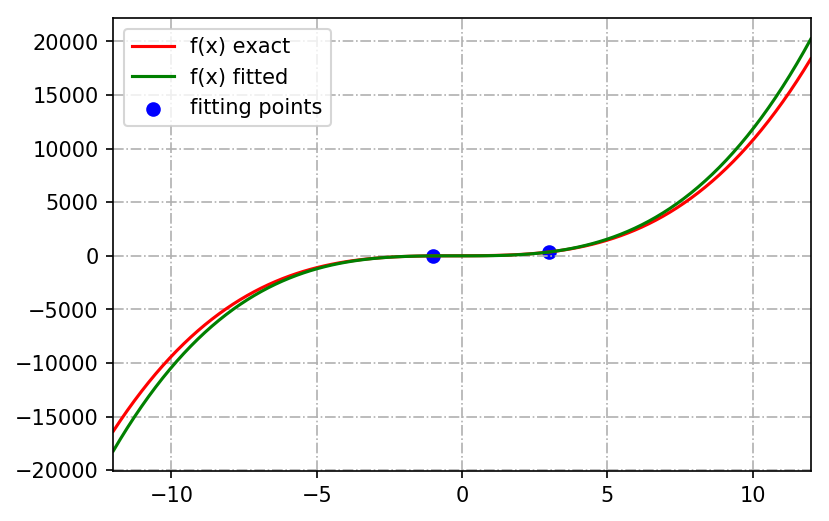

Random points are:
[-1  3]
Coefficients of random polynomial:
a0=10
a1=7
a2=7
a3=10


In [7]:
fitted_coef = results.params

# Plotting
plt.clf()

fig=plt.figure(dpi = 150)
ax = fig.add_subplot(1, 1, 1)

# plot the function
r = np.linspace(-12,12,100)
plt.scatter(x, [PolyEvaluate(coef, a) for a in x], c='b', label="fitting points")
plt.plot(r, [PolyEvaluate(coef, a) for a in r], 'r', label=f"f(x) exact")
plt.plot(r, [PolyEvaluate(fitted_coef, a) for a in r], 'g', label=f"f(x) fitted")

plt.legend()
plt.grid(linestyle="-.")
plt.xlim(-12, 12)
plt.show()

print(f"Random points are:\n{x}")
print(f"Coefficients of random polynomial:")
for i, c in enumerate(coef):
    print(f"a{i}={c}")

It looks as if the two graphs are very similar, in fact they both pass through the points (x, y) selected. The fitted polynomial lacks information and this is why even though he can reconstruct much of the curve it has long tails where no information is provided.

### Number of drawn points larger than polynomial degree

In [8]:
n_points = 10

assert n_points>=t
X, y, x = _generate_data(n_points, degree, coef)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())
print(f"Coefficients of random polynomial:")
for i, c in enumerate(coef):
    print(f"a{i}={c}")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.671e+30
Date:                Sun, 16 Feb 2020   Prob (F-statistic):           3.75e-90
Time:                        10:07:23   Log-Likelihood:                 250.17
No. Observations:                  10   AIC:                            -492.3
Df Residuals:                       6   BIC:                            -491.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.0000   2.57e-12   3.89e+12      0.0

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


Here you can see that now the coefficients are matched perfectly (if you compare with the original data) and the standard error of them is very small. A large $t$ indicates that we have strong evidence that these values are correct (using t-statistics). See that we recovered the secret!. Let's again plot the two lines, the origial polynomial and the fitted one.

<Figure size 432x288 with 0 Axes>

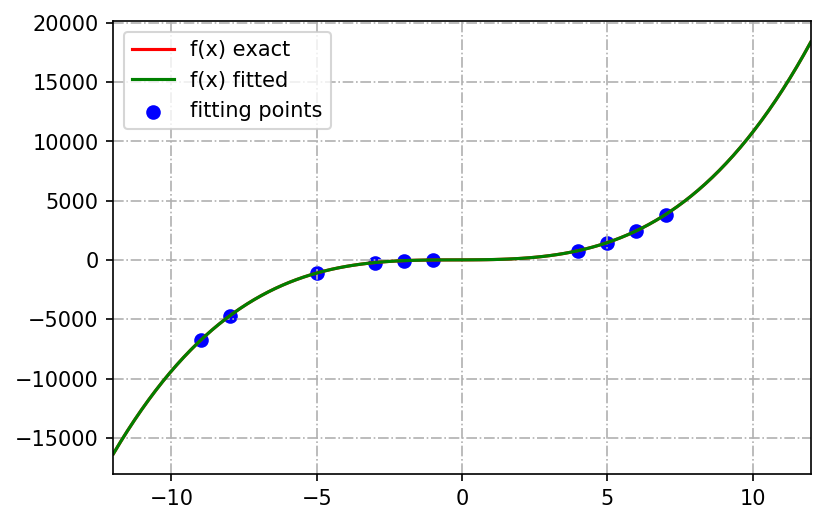

Random points are:
[ 4 -5 -3 -1 -2 -9 -8  6  7  5]
Coefficients of random polynomial:
a0=10
a1=7
a2=7
a3=10


In [9]:
fitted_coef = results.params

# Plotting
plt.clf()

fig=plt.figure(dpi = 150)
ax = fig.add_subplot(1, 1, 1)

# plot the function
r = np.linspace(-12,12,100)
plt.scatter(x, [PolyEvaluate(coef, a) for a in x], c='b', label="fitting points")
plt.plot(r, [PolyEvaluate(coef, a) for a in r], 'r', label=f"f(x) exact")
plt.plot(r, [PolyEvaluate(fitted_coef, a) for a in r], 'g', label=f"f(x) fitted")

plt.legend()
plt.grid(linestyle="-.")
plt.xlim(-12, 12)
plt.show()

print(f"Random points are:\n{x}")
print(f"Coefficients of random polynomial:")
for i, c in enumerate(coef):
    print(f"a{i}={c}")

This time both lines lie one on top of the other. We have "perfectly" reconstructed the original polynomial by sampling $t$>$n$ points.


## Lagrange polynomial reconstruction

The reconstruction shown above has a strong assumption, this is, we consider that the coefficients of the polynomial are real numbers. This means that if we find that the secret is 10 with a very small standard deviation we are quite sure that the value is close to 10 but it could also be 10.00000001. We are lucky because we work on the field of polynomials with coefficients in $\mathbb{Z}_p$ and so the coefficinets are constrained by the natural numbers. this is:

$$f(x)=\sum_{i=0}^{n}a_ix^i=a_0+a_1x+a_2x^2+\cdots+a_{t-1}x^{t-1}$$

where $a_i$ coefficients belong to the integer modulo $p$ field ($a_i \in \mathbb{Z}_p$). 

This kind of polynomials on $\mathbb{Z}_p$ can be reconstructed exactly using [Lagrange interpolation](https://en.wikipedia.org/wiki/Lagrange_polynomial). 

Lagrange interpolation theorem: Given $t$ distinct points ($x_i$, $y_i$) where $y_i=f(x)$ and $f(x)$ is a poloynomial of degree less than $t$ then $f(x)$ is determined by

$$f(x)=\sum_{i=1}^ty_i\prod_{j=1, j!=n}^{t}\frac{x-x_j}{x_i-x_j}$$

We are interested in recovering the secret, thus on the value $f(0)$

$$s=x_0=f(0)=\sum_{i=1}^ty_i\prod_{j=1, j!=n}^{t}\frac{x_j}{x_j-x_i}$$

Let's code a function that calculates the value of the polynomial at any given point given the shares (points).

In [10]:
def LagrangeInterpolation(x, points):
    """
    Given t shares calculate the interpolation of the polynomial of degree
    t-1 at point x.
    Input: 
        x: the point where we want to calculate f(x)
        points: a set of values (xi, yi) randomly sampled from the polynomial
    """
    #Check all points are distinct
    distinct_xi = set([x for x,y in points])
    if len(points)!=len(distinct_xi):
        raise ValueError("Points at which we evaluate the polynomial must be all different")
    
    summands = []
    for i, (xi, yi) in enumerate(points):
        val = 1
        for j, (xj, yj) in enumerate(points):
            if i!=j:
                #val=val*(x-xj)*InverseFermat((xi-xj), p)%p
                val*=(x-xj)/(xi-xj)
                
        val*=yi
        #val*=yi%p
        summands.append(val)
    
    # cast it to integer (has to be since x and y are all integers and f is polynomial)
    # same time to avoid numerical errors we round the number
    return int(round(sum(summands)))

**Definition**: A $(t, n)$ threshold secret sharing scheme is a method for $n$ parties to carry shares si of
a message s such that any $t$ of the them to reconstruct the message, but so that no $t − 1$
of them can easy do so. The threshold scheme is perfect if knowledge of $t − 1$ or fewer
shares provides no information regarding $s$.

This is perfect in this scheme, we can reconstruct the polynomial of degree $t-1$ where the number of parties is $n>t-1$. I.e. the minimum number of participants to reconstruct the secret is $n=t$.

In [11]:
bits = 32
p = RandomPrime(bits, 40)

degree = 5
secret = randrange(1, p)

coef = RandomPolynomial(secret, degree, p)
print(f"Generating a random polynomial of degree {degree} and secret {secret} over prime number {p}")
print(f"Coefficients of random polynomial:")
for i, c in enumerate(coef):
    print(f"a{i}={c}")

Generating a random polynomial of degree 5 and secret 1227012557 over prime number 3619984273
Coefficients of random polynomial:
a0=1227012557
a1=3156276775
a2=2900018710
a3=1404978978
a4=78114824
a5=1386459522


In [12]:
t = degree+1
_, y, x = _generate_data(t, degree, coef)
points = list(zip(list(x), list(y)))

In [13]:
points

[(-9, -82173044592184),
 (5, 4646639007682),
 (2, 75996014659),
 (-8, -45669318538731),
 (3, 417967408268),
 (-4, -1454653605359)]

In [14]:
print(f"We want to find the secret of a polynomial of degree {degree}, we need t={t} shares to reconstruct it.")
print("Random shares generated:\n")
for xi, yi in points:
    print(f"f({xi})={yi}")

We want to find the secret of a polynomial of degree 5, we need t=6 shares to reconstruct it.
Random shares generated:

f(-9)=-82173044592184
f(5)=4646639007682
f(2)=75996014659
f(-8)=-45669318538731
f(3)=417967408268
f(-4)=-1454653605359


In [15]:
print("Evaluating at different points using evaluation from coefficinets and interpolation:")
for i in range(-5, 5):
    f = PolyEvaluate(coef, i)%p
    lag = LagrangeInterpolation(i, points)%p
    print(f"x={i}, f({i})={f}, f({i})_lagrange={lag}")
    
    if f!=lag:
        print("\nLagrange interpolation or polynomial evaluation is wrong, values do not coincide\n\n")
    

Evaluating at different points using evaluation from coefficinets and interpolation:
x=-5, f(-5)=360358900, f(-5)_lagrange=360358900
x=-4, f(-4)=580072387, f(-4)_lagrange=580072387
x=-3, f(-3)=480029595, f(-3)_lagrange=480029595
x=-2, f(-2)=2837614325, f(-2)_lagrange=2837614325
x=-1, f(-1)=1877415089, f(-1)_lagrange=1877415089
x=0, f(0)=1227012557, f(0)_lagrange=1227012557
x=1, f(1)=2912892820, f(1)_lagrange=2912892820
x=2, f(2)=3596329199, f(2)_lagrange=3596329199
x=3, f(3)=1669216873, f(3)_lagrange=1669216873
x=4, f(4)=729923234, f(4)_lagrange=729923234


Now we can recover the secret with the points, we just need to evaluate $f(0)$:

In [16]:
recovered_secret = LagrangeInterpolation(0, points)
if recovered_secret!=secret:
    print("Something went wrong, we couldn't recover the secret")
print(f"Our successfully recovered secret is {recovered_secret} :)")

Our successfully recovered secret is 1227012557 :)


We've recovered the secret well. This shows you how the protocol should work. Recall that we've not worked on modulo $p$ in the $x$ and $y$ of the polynomial, just on the coefficients. We have to restrict ourselves to modulo operation in all the following. I've implemented this in a library.

## Packing up the concepts in a package

First let's import the libraries, there's documentation on how to use them (e.g. type help(ShamirRandomPolynomial) on a python cell)

In [17]:
from smpc import ShamirRandomPolynomial, DrawPolynomialPoints, LagrangeInterpolation, PolyEvaluateModulo

In [18]:
help(ShamirRandomPolynomial)

Help on function ShamirRandomPolynomial in module smpc:

ShamirRandomPolynomial(s: int, n: int, p: int) -> List[int]
    Calculates the coeficients living on a field Zp for a polynomial of degree n
    Input:
        s: secret, independent term of the polynomial
        n: degree of the polynomial, we need t=n+1 to reconstruct
        p: prime number to generate the coeffients
    Output:
        A list of integers with the coefficients [a0, a1, a2,...,an]



In [19]:
help(DrawPolynomialPoints)

Help on function DrawPolynomialPoints in module smpc:

DrawPolynomialPoints(shares: int, coef: List[int], p: int, rng: Tuple[int, int] = (0, 20)) -> List[Tuple[int, int]]
    Draw distinct points from a coefficient of certain degree and coefficients in a list
    Inputs:
        shares: number of points to be drawn randomly
        coef: the list of coefficients of the polynomial. Degree is len(coef)-1
        p: the prime over which the ring is generated
        rng: range of x to be selected randomly.
    
    returns:
        A list of tuples [(x0, f(x0)), (x1, f(x1)),...,(x_npoints-1, f(x_npoints-1))]
        those are random points (not repeated) sampled from the polynomial with x in the range
        of the parameter rng



In [20]:
help(LagrangeInterpolation)

Help on function LagrangeInterpolation in module smpc:

LagrangeInterpolation(x: int, shares: List[Tuple[int, int]], p: int) -> int
    Given t shares calculate the interpolation of the polynomial of degree
    t-1 at point x.
    Input: 
        x: the point where we want to calculate f(x)
        shares: a set of values (xi, yi) randomly sampled from the polynomial
    Returns:
        the value f(x) for the polynomial with degree len(points)-1 (fully determined)



In [21]:
help(PolyEvaluateModulo)

Help on function PolyEvaluateModulo in module smpc:

PolyEvaluateModulo(coef: List[int], x: int, p: int) -> int
    Horner's method to evaluate polynomial
    coef is a list of the coefficients [a0, a1,..., an], note this is 
    modulo p evaluation. Not real valued polynomials
    
    Input:
        coef: list of coefficients of the polynomial
        x: input where we want to evaluate the polynomial (x<p)
        p: the prime number over which the ring of polynomials is defined
    Returns:
        f(x), the evaluation of the polynomial at x in modulo



Let's do a quick example on a large field

In [22]:
bits = 128
p = RandomPrime(bits, 100)

degree = 6
secret = 100

coef = ShamirRandomPolynomial(s=secret, n=degree, p=p)

print(f"Ring of polynomials with degree {degree} and prime {p}")
print(f"Selected random polynomial on p:\n")
for i, elem in enumerate(coef):
    print(f"a{i}={elem}")

Ring of polynomials with degree 6 and prime 281801681076690368715661516957416055099
Selected random polynomial on p:

a0=100
a1=216077827504967834064076824823682194361
a2=85492896266225514782476960369454921927
a3=241791015826019246713014901803836622073
a4=130891076047556679257833189550241805298
a5=84413767897826772550006072233156420744
a6=131811120766210846593196348434315467268


In [23]:
points = DrawPolynomialPoints(degree+1, coef, p, rng=(0, p))
print("Random points drawn from polynomial generated above:\n")
for point in points:
    interpolated = LagrangeInterpolation(point[0], points, p)
    if interpolated != point[1]:
        print("Some Error occurred, the interpolation may not be correct")
    else:
        print(f"x={point[0]}, f(x)={point[1]}, correct interpolation!")

Random points drawn from polynomial generated above:

x=53888404193589085629177333628082274450, f(x)=211330460567880246270721017045769343925, correct interpolation!
x=59859692460262124638489064287006304260, f(x)=92557766924219782116742002690384425740, correct interpolation!
x=60920705205508609908543232324825245621, f(x)=7984341415379903539862273405402357878, correct interpolation!
x=213326299303796345894058133909205529440, f(x)=30962035174868611414455941960944025149, correct interpolation!
x=57150883061138946191257868792190458923, f(x)=73964615241410196784799044016074140261, correct interpolation!
x=227968066967775006767292317132922247400, f(x)=123817533802778097594822758571292501546, correct interpolation!
x=92552440460050387802082404733703340841, f(x)=254567490852951920337126407419212484121, correct interpolation!


A useful function is RevealSecret that gives us the intercept (or secret) of the polynomial given the shares

In [24]:
from smpc import RevealSecret

print(f"Reveling secret: {RevealSecret(points, p)}")

Reveling secret: 100


We've seen that this can be extended to large polynomial rings and that the interpolation works (in modulo sense). Now is time to define operations on polynomials.

## Sum on Shamir polynomials

All this construction is useful to sum two secrets in a privacy preserving way. Say Alice and Bob both generate two random polynomials of degree $t-1$ (we need n=t parties to reconstruct) with their secret independent terms as $s_A$ and $s_B$, respectively. Can we use other parties to compute $s^A+s^B$?. The answer obviously is affirmative because the sum of two polynomials of the same degree results in a polynomial whose coefficients are the sum of the previous two. This is,

$$f^A(x)= s^A+a^A_1x+a^A_2x^ 2+\cdots a^A_{t-1}x^{t-1}$$
$$f^B(x)= s^B+a^B_1x+a^B_2x^ 2+\cdots a^B_{t-1}x^{t-1}$$
$$f^A(x)+f^B(x)= (s^A+s^B)+(a^A_1+a^B_1)x+(a^A_2+a^B_2)x^2+\cdots (a^A_{t-1}+a^B_{t-1})x^{t-1}$$

Therefore the reconstruction of the secret sum is:
$$s= s^A+s^B$$
as we would expect.

To do this protocol first Alice and Bob have to agree on three things, first the prime number $p$ they will use for their randomly generated polynomials, then the degree of the polynomials and finally the evaluation points

In [31]:
bits = 128
p = RandomPrime(bits, 100)

t = 6
deg = t-1

# agreed evaluation points for the polynomials, make sure to not
# include x=0. If we send this to any party it will reveal our secret
eval_points = [i for i in range(1, t+2)]

# Each party has a secret that want to sum
sa = randrange(1, 5000)
sb = randrange(1, 5000)

poly_Alice = ShamirRandomPolynomial(sa, deg, p)
poly_Bob = ShamirRandomPolynomial(sb, deg, p)

shares_Alice = [(i, PolyEvaluateModulo(poly_Alice, i, p)) for i in eval_points]
shares_Bob = [(i, PolyEvaluateModulo(poly_Bob, i, p)) for i in eval_points]

In [32]:
print(f"Alice's secret sa: {sa}")
print(f"Bob's secret sb: {sb}")
print()

print("Polynomial Generated Secretly by Alice:")
for i, c in enumerate(poly_Alice):
    print(f"a{i}={c}")

print()
print("Polynomial Generated Secretly by Bob:")
for i, c in enumerate(poly_Bob):
    print(f"a{i}={c}")
print()

print("Alice's Shares")
for x, y in shares_Alice:
    print(f"x={x}, f(x)={y}")

print()
print("Bobs's Shares")
for x, y in shares_Bob:
    print(f"x={x}, f(x)={y}")

Alice's secret sa: 3752
Bob's secret sb: 2865

Polynomial Generated Secretly by Alice:
a0=3752
a1=241525100854861057437587772976660947439
a2=7362367688571913674438352934908609385
a3=81449930889394444523846755694907910635
a4=37066285325674934030459246258019089645
a5=241362899234977350817765975544618874530

Polynomial Generated Secretly by Bob:
a0=2865
a1=72617055030650422620395956901999626163
a2=49395730955412108846756450881413715322
a3=229789111485751465158913003204669629237
a4=8747509759361160423585723199656955313
a5=3360472660671933629605182215735042013

Alice's Shares
x=1, f(x)=283185399703225357117612868524206399029
x=2, f(x)=38918115891863538791490349145966986177
x=3, f(x)=178463881784186316146825396136617491028
x=4, f(x)=197256001112174550503898550960309952049
x=5, f(x)=115204960227689792091720512180827646311
x=6, f(x)=137939750176865475196278061174036760959
x=7, f(x)=318049188774498113308779987840338064682

Bobs's Shares
x=1, f(x)=38328695601592747312771081518565934556
x=2, f(x)

Now they both send their shares to the different parties, at least $t$ with every party having the same point of evaluation.

In [33]:
for i, ((xa, ya), (xb, yb)) in enumerate(zip(shares_Alice, shares_Bob)):
    assert xa==xb
    print(f"Party {i} gets shares evaluated at x={xa}\n\tfrom Alice f(x)_A={ya}\n\tfrom Bob f(x)_B={yb}\n")

Party 0 gets shares evaluated at x=1
	from Alice f(x)_A=283185399703225357117612868524206399029
	from Bob f(x)_B=38328695601592747312771081518565934556

Party 1 gets shares evaluated at x=2
	from Alice f(x)_A=38918115891863538791490349145966986177
	from Bob f(x)_B=149556917028461041258462500870680525300

Party 2 gets shares evaluated at x=3
	from Alice f(x)_A=178463881784186316146825396136617491028
	from Bob f(x)_B=252332293601125088915019000637904989238

Party 3 gets shares evaluated at x=4
	from Alice f(x)_A=197256001112174550503898550960309952049
	from Bob f(x)_B=305012574555273988532230707315250442072

Party 4 gets shares evaluated at x=5
	from Alice f(x)_A=115204960227689792091720512180827646311
	from Bob f(x)_B=57759979741889078351384527429564869911

Party 5 gets shares evaluated at x=6
	from Alice f(x)_A=137939750176865475196278061174036760959
	from Bob f(x)_B=106960287488384658890856483197556243545

Party 6 gets shares evaluated at x=7
	from Alice f(x)_A=31804918877449811330877

Now each party performs the sum modulo p

In [34]:
shared_sum = []
for i, ((xa, ya), (xb, yb)) in enumerate(zip(shares_Alice, shares_Bob)):
    assert xa==xb
    shared_sum.append((xa, (ya+yb)%p))

With the sum of shares we can reconstruct the secret

In [35]:
s_reconstructed = RevealSecret(shared_sum, p)
assert s_reconstructed==(sa+sb)%p

print(f"The original sum of secrets is {(sa+sb)%p}")
print(f"The reconstructed secret from the shared sums is {s_reconstructed}")
print("Computation of the sum can be outsourced!")

The original sum of secrets is 6617
The reconstructed secret from the shared sums is 6617
Computation of the sum can be outsourced!


## Multiplication on Shamir polynomials

Multiplication can be defined in Shamir polynomials but it is a little bit tricky. 

As before, Alice and Bob both generate two random polynomials of degree $t-1$ (we need n=t parties to reconstruct) with their secret independent terms as $s_A$ and $s_B$, respectively. We now look for the product $s^A\times s^B$. 

$$f^A(x)= s^A+a^A_1x+a^A_2x^ 2+\cdots a^A_{t-1}x^{t-1}$$
$$f^B(x)= s^B+a^B_1x+a^B_2x^ 2+\cdots a^B_{t-1}x^{t-1}$$
$$f^A(x)\times f^B(x)= (s^A\times s^B)+(s^A\times a^B_1+s^B\times a^A_1)x+\cdots +(a^A_{t-1}+a^B_{t-1})x^{2t-2}$$

From above you can see that now the polynomial has increased in degree to $2t-2$ so we need at least $n=2t-1$ to reconstruct the secret $s^A\times s^B$. We can say that Shamir secret sharing is multplicative for $n>2t-2$, let's code this.

In [36]:
bits = 128
t = 5
deg = t-1
points = 2*t-1


p = RandomPrime(bits, 100)

# agreed evaluation points for the polynomials, make sure to not
# include x=0. If we send this to any party it will reveal our secret
eval_points = [i for i in range(1, points+1)]

# Each party has a secret that want to sum
sa = randrange(1, 5000)
sb = randrange(1, 5000)

poly_Alice = ShamirRandomPolynomial(sa, deg, p)
poly_Bob = ShamirRandomPolynomial(sb, deg, p)

shares_Alice = [(i, PolyEvaluateModulo(poly_Alice, i, p)) for i in eval_points]
shares_Bob = [(i, PolyEvaluateModulo(poly_Bob, i, p)) for i in eval_points]

In [37]:
print(f"Alice's secret sa: {sa}")
print(f"Bob's secret sb: {sb}")
print()

print("Polynomial Generated Secretly by Alice:")
for i, c in enumerate(poly_Alice):
    print(f"a{i}={c}")

print()
print("Polynomial Generated Secretly by Bob:")
for i, c in enumerate(poly_Bob):
    print(f"a{i}={c}")
print()

print("Alice's Shares")
for x, y in shares_Alice:
    print(f"x={x}, f(x)={y}")

print()
print("Bobs's Shares")
for x, y in shares_Bob:
    print(f"x={x}, f(x)={y}")

Alice's secret sa: 3281
Bob's secret sb: 1497

Polynomial Generated Secretly by Alice:
a0=3281
a1=70449763931174533647779005524411075524
a2=6062684027529235921790162878670028666
a3=275542976358695572499800029359499769
a4=138872504967356839613455037118201312994

Polynomial Generated Secretly by Bob:
a0=1497
a1=36083788980949627063951380623492909263
a2=183569182960653027641942165372497315874
a3=256084404811463771164221905275971400839
a4=27218757032269292152574149244201923361

Alice's Shares
x=1, f(x)=215660495902419304755524005550641920234
x=2, f(x)=69325925195015697622763187244702450902
x=3, f(x)=179858729547176655916765905895447416072
x=4, f(x)=116860474831242885471169637534835702776
x=5, f(x)=205107554951642229781161116315105683072
x=6, f(x)=235668546252651163472790518150499200629
x=7, f(x)=239233794873737896221382950532227178776
x=8, f(x)=228338887631114671445401289256814417819
x=9, f(x)=197364652017737766306446178426099595041

Bobs's Shares
x=1, f(x)=24517960466688801671655243724450

In [38]:
for i, ((xa, ya), (xb, yb)) in enumerate(zip(shares_Alice, shares_Bob)):
    assert xa==xb
    print(f"Party {i} gets shares evaluated at x={xa}\n\tfrom Alice f(x)_A={ya}\n\tfrom Bob f(x)_B={yb}\n")

Party 0 gets shares evaluated at x=1
	from Alice f(x)_A=215660495902419304755524005550641920234
	from Bob f(x)_B=245179604666888016716552437244508348151

Party 1 gets shares evaluated at x=2
	from Alice f(x)_A=69325925195015697622763187244702450902
	from Bob f(x)_B=197301311391157792776987093592114631811

Party 2 gets shares evaluated at x=3
	from Alice f(x)_A=179858729547176655916765905895447416072
	from Bob f(x)_B=52758040137257160904070304045019674360

Party 3 gets shares evaluated at x=4
	from Alice f(x)_A=116860474831242885471169637534835702776
	from Bob f(x)_B=145639821407201562870073658922960052979

Party 4 gets shares evaluated at x=5
	from Alice f(x)_A=205107554951642229781161116315105683072
	from Bob f(x)_B=174404208885230945578362514048242492098

Party 5 gets shares evaluated at x=6
	from Alice f(x)_A=235668546252651163472790518150499200629
	from Bob f(x)_B=232982395911600566287944643832364674128

Party 6 gets shares evaluated at x=7
	from Alice f(x)_A=2392337948737378962213

All parties perform Shurr multiplication of their shares.

In [39]:
shared_mult = []
for i, ((xa, ya), (xb, yb)) in enumerate(zip(shares_Alice, shares_Bob)):
    assert xa==xb
    shared_mult.append((xa, (ya*yb)%p))

In [45]:
s_reconstructed = RevealSecret(shared_mult, p)
assert s_reconstructed==(sa*sb)%p

print(f"The original multiplication of secrets is {(sa*sb)%p}")
print(f"The reconstructed secret using the products is {s_reconstructed}")
print("Computation of the product can be outsourced! (for n>2t-2)")

The original multiplication of secrets is 4911657
The reconstructed secret using the products is 4911657
Computation of the product can be outsourced! (for n>2t-2)
